In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [88]:
import os
import cv2
import numpy as np
import pickle
import tensorflow as tf
import tensorflow.keras as K
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt

%matplotlib inline

In [89]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.2.0
Eager execution: True


In [185]:
# loading the dataset
file = open('/content/drive/My Drive/ColabData/pokemon_arrays_full.pkl', 'rb')
images = pickle.load(file)
file.close()

print("Number of images = " + str(len(images)))
print("Shape of each image = " + str(images[0].shape))

Number of images = 10665
Shape of each image = (100, 100, 3)


In [186]:
# reshaping the data
X_train = np.reshape(images, (len(images), 100, 100, 3))

print(X_train.shape)

# print(X_train[0][1])

(10665, 100, 100, 3)


In [187]:
# normalizing
X_train = X_train/255.
print(X_train.shape)
# print(X_train[0][1])

(10665, 100, 100, 3)


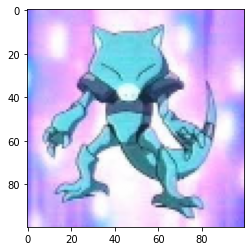

In [188]:
plt.imshow(X_train[0])

In [189]:
imageSize = 100

In [191]:
BUFFER = X_train.shape[0]
BATCH_SIZE = 128      #256

trainingData = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER).batch(BATCH_SIZE)

# just to check dimensions
lst = list(trainingData.as_numpy_iterator())
print(len(lst))              # batches
print(len(lst[0]))           # batch size
print(len(lst[-1]))          # last batch size
print(len(lst[0][0]))        # height
print(len(lst[0][0][0]))     # width
print(len(lst[0][0][0][0]))  # channels/depth

84
128
41
100
100
3


# Models
- Discriminator model
- Generator model

In [192]:
K.backend.clear_session()

def getDiscriminatorModel():
    model = K.models.Sequential([
        layers.Conv2D(32, (3, 3), padding = 'same', input_shape = (imageSize, imageSize, 3)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2D(64, (3, 3), strides = (2, 2), padding = 'same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2D(128, (3, 3), strides = (2, 2), padding = 'same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2D(256, (3, 3), padding = 'same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Flatten(),
        layers.Dense(512),
        layers.LeakyReLU(),

        layers.Dense(1),
        layers.Activation('sigmoid')
    ])
    
    return model

In [193]:
discriminator = getDiscriminatorModel()

In [194]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       7

In [195]:
# from the summary above, we see that we get a 25x25x128 just before flattenning
genSize = 25
depth = 256    #128

def getGeneratorModel():
    model = K.models.Sequential([
        layers.Dense(genSize*genSize*depth, input_shape = (100,)),
        
        # shouldn't explode
        layers.BatchNormalization(),
        layers.Reshape((genSize, genSize, depth)),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(256, (3, 3), padding = 'same'),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same'),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(64, (3, 3), padding = 'same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        # at this point the image is upsampled twice so we get the original image size
        layers.Conv2DTranspose(3, (3, 3), padding = 'same'),
        layers.Activation('tanh')
    ])
    
    return model

In [196]:
generator = getGeneratorModel()

In [197]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 160000)            16160000  
_________________________________________________________________
batch_normalization_4 (Batch (None, 160000)            640000    
_________________________________________________________________
reshape (Reshape)            (None, 25, 25, 256)       0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 25, 25, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 25, 25, 256)       590080    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 25, 25, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 50, 50, 128)      

In [198]:
# testing the generator with some noise
noise = tf.random.normal([1, 100])
genImg = generator(noise, training = False)
print(genImg.shape)

(1, 100, 100, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


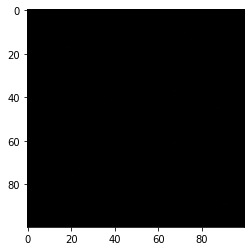

In [199]:
plt.imshow(genImg[0, :, :, :])

# Optimizers

In [200]:
genOpt = K.optimizers.Adam(lr = 2e-4, beta_1 = 0.5)   # lr = 1e-4
discOpt = K.optimizers.SGD(lr = 1e-4)   # default beta_1 = 0.0

# Losses

In [201]:
def getGeneratorLoss(fakePreds):
    # adding real prediction loss for generator as well and seeing how it performs
    # note - did not perform well
    # losses flipped in discriminator
    # rLoss = K.losses.BinaryCrossentropy()(tf.zeros_like(realPreds), realPreds)
    # fLoss = K.losses.BinaryCrossentropy()(tf.ones_like(fakePreds), fakePreds)
    # totalLoss = rLoss + fLoss
    return K.losses.BinaryCrossentropy()(tf.ones_like(fakePreds), fakePreds)
    # return totalLoss

In [202]:
def getDiscriminatorLoss(realPreds, fakePreds):
    rLoss = K.losses.BinaryCrossentropy()(tf.ones_like(realPreds), realPreds)
    fLoss = K.losses.BinaryCrossentropy()(tf.zeros_like(fakePreds), fakePreds)
    totalLoss = rLoss + fLoss
    return totalLoss

# Training

In [207]:
EPOCHS = 10        # 50

In [208]:
genLoss = []
discLoss = []

def train(dataset, epochs):

    gLoss = None
    dLoss = None

    for epoch in range(epochs):

        for pokemon in dataset:
            gLoss, dLoss = trainStep(pokemon)
        
        genLoss.append(gLoss)
        discLoss.append(dLoss)

        print("Running epoch : " + str(epoch + 1))

        if (epoch+1)%5 == 0:
          print("Generator loss : " + str(gLoss))
          print("Discriminator loss : " + str(dLoss))

In [209]:
# this decorator is used to 
@tf.function
def trainStep(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    
    with tf.GradientTape() as gen, tf.GradientTape() as disc:
        genImages = generator(noise, training = True)
        
        realOP = discriminator(images, training = True)
        fakeOP = discriminator(genImages, training = True)
        
        genLoss = getGeneratorLoss(fakeOP)
        discLoss = getDiscriminatorLoss(realOP, fakeOP)
        
    genGrads = gen.gradient(genLoss, generator.trainable_variables)
    discGrads = disc.gradient(discLoss, discriminator.trainable_variables)
    
    genOpt.apply_gradients(zip(genGrads, generator.trainable_variables))
    discOpt.apply_gradients(zip(discGrads, discriminator.trainable_variables))

    return genLoss, discLoss

In [210]:
train(trainingData, EPOCHS)

Running epoch : 1
Running epoch : 2
Running epoch : 3
Running epoch : 4
Running epoch : 5
Generator loss : tf.Tensor(0.14313237, shape=(), dtype=float32)
Discriminator loss : tf.Tensor(6.9857388, shape=(), dtype=float32)
Running epoch : 6
Running epoch : 7
Running epoch : 8
Running epoch : 9
Running epoch : 10
Generator loss : tf.Tensor(0.37450472, shape=(), dtype=float32)
Discriminator loss : tf.Tensor(2.9810305, shape=(), dtype=float32)


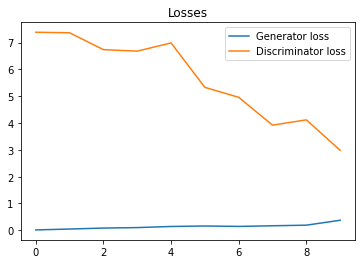

In [211]:
plt.plot(range(EPOCHS), genLoss, label = "Generator loss")
plt.plot(range(EPOCHS), discLoss, label = "Discriminator loss")
plt.legend()
plt.title('Losses')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


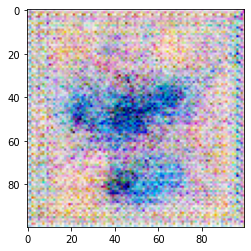

In [212]:
plt.imshow(generator(tf.random.normal([1, 100]))[0, :, :, :])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


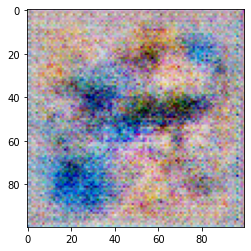

In [213]:
plt.imshow(generator(tf.random.normal([1, 100]))[0, :, :, :])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


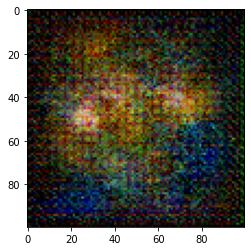

In [214]:
plt.imshow(generator(tf.random.normal([1, 100]))[0, :, :, :])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


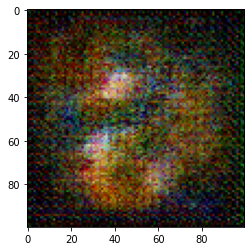

In [215]:
plt.imshow(generator(tf.random.normal([1, 100]))[0, :, :, :])

In [ ]:
generator.save('generator_50ep_adam_lr0.00001_b10.5.h5')
discriminator.save('discriminator_50ep_adam_lr0.00001_b10.5_sgd_lr0.00001.h5')